In [1]:
import os
import torch
# import cv2
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from kornia.feature import DenseSIFTDescriptor, SIFTDescriptor
from kmeans_pytorch import kmeans
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

In [2]:
print(torch.cuda.is_available())
device = torch.device('cuda:0')
print(torch.cuda.get_device_name())

True
NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [4]:
code_folder = os.getcwd()
annotation_folder = os.path.join(code_folder,'../../dataset/Stanford/Annotation')
images_folder = os.path.join(code_folder,'../../dataset/Stanford/Images')

In [5]:
transform = transforms.Compose([transforms.Resize((255,255)), transforms.Grayscale(num_output_channels=1), transforms.ToTensor()])
dataset = datasets.ImageFolder(images_folder, transform=transform)

In [6]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

In [7]:
descs = None
labels_all = None
for images, labels in dataloader:
    SIFT = SIFTDescriptor(patch_size=255)
    desc = SIFT(images)
    desc = desc.to(device=device)
    labels = labels.to(device=device)
    if descs is None:
        descs = desc
        labels_all = labels
    else:
        descs = torch.cat((descs, desc))
        labels_all = torch.cat((labels_all, labels))
print(descs.shape)

Error: Canceled future for execute_request message before replies were done

In [7]:
for cluster in range(10):
    cluster_ids_x, cluster_centers = kmeans(X=descs, num_clusters=3, distance='euclidean', device=device)
    cluster_ids_x = cluster_ids_x.to(device=device)
    diff = torch.abs(cluster_ids_x - labels_all)
    diff[diff == 2] = 1
    error_rate = diff.sum() / diff.shape[0]
    accuracy = 1 - error_rate
    print(cluster)
    print(accuracy)

running k-means on cuda:0..


[running kmeans]: 9it [00:00, 279.54it/s, center_shift=0.000079, iteration=9, tol=0.000100]


0
tensor(0.4075, device='cuda:0')
running k-means on cuda:0..


[running kmeans]: 9it [00:00, 417.79it/s, center_shift=0.000030, iteration=9, tol=0.000100]


1
tensor(0.4329, device='cuda:0')
running k-means on cuda:0..


[running kmeans]: 13it [00:00, 366.03it/s, center_shift=0.000040, iteration=13, tol=0.000100]


2
tensor(0.4194, device='cuda:0')
running k-means on cuda:0..


[running kmeans]: 9it [00:00, 446.60it/s, center_shift=0.000020, iteration=9, tol=0.000100]

3


tensor(0.2649, device='cuda:0')
running k-means on cuda:0..


[running kmeans]: 9it [00:00, 358.52it/s, center_shift=0.000082, iteration=9, tol=0.000100]


4
tensor(0.2784, device='cuda:0')
running k-means on cuda:0..


[running kmeans]: 10it [00:00, 406.17it/s, center_shift=0.000037, iteration=10, tol=0.000100]


5
tensor(0.2818, device='cuda:0')
running k-means on cuda:0..


[running kmeans]: 12it [00:00, 382.17it/s, center_shift=0.000040, iteration=12, tol=0.000100]


6
tensor(0.2818, device='cuda:0')
running k-means on cuda:0..


[running kmeans]: 8it [00:00, 322.59it/s, center_shift=0.000014, iteration=8, tol=0.000100]


7
tensor(0.4211, device='cuda:0')
running k-means on cuda:0..


[running kmeans]: 15it [00:00, 234.83it/s, center_shift=0.000081, iteration=15, tol=0.000100]


8
tensor(0.2445, device='cuda:0')
running k-means on cuda:0..


[running kmeans]: 7it [00:00, 271.05it/s, center_shift=0.000088, iteration=7, tol=0.000100]


9
tensor(0.3379, device='cuda:0')


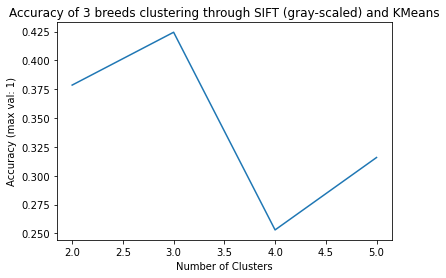

In [29]:
descs_numpy = descs.cpu().detach().numpy()
accuracies = [0]*4
for cluster in range(2,6):
    kmeans_results = KMeans(n_clusters=cluster).fit(descs_numpy)
    results_torch = torch.from_numpy(kmeans_results.labels_).to(device)
    diff = torch.abs(results_torch - labels_all)
    diff[diff != 0] = 1
    error_rate = diff.sum() / diff.shape[0]
    accuracies[cluster-2] = 1 - error_rate.item()
plt.plot(np.arange(2,6,1), accuracies)
plt.xlabel('Number of Clusters')
plt.ylabel('Accuracy (max val: 1)')
plt.title('Accuracy of 3 breeds clustering through SIFT (gray-scaled) and KMeans')
plt.show()